In [18]:
import torch
from tqdm import tqdm
from pathlib import Path
import json
from datetime import datetime
#from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
# import pandas as pd
# import random
# from collections import Counter

from transformers import AutoTokenizer, GPT2LMHeadModel
from transformers import BertTokenizerFast
import os
# os.environ["TOKENIZERS_PARALLELISM"] = "false" #необходимо на виртуальной машине Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
# ./src
from src.data_utils import samples_preparation, load_datasets,load_samples,dataset_preparation#,load_and_clean_data, prepare_training_pairs
#from src.next_token_dataset import TweetsDataset
from src.lstm_model import NextPhrasePredictionRNN
from src.eval_lstm import vevaluate3, test_model, analyze_predictions, analyze_error_patterns, show_detailed_examples
from src.visualization import create_visualization
# для тестирования и сравнения тестов по lstm и distilgpt2
from src.test_models import test_lstm_model, test_transformer_model_new,prepare_transformer_dataset_from_loader, test_transformer_with_generation, compare_models
# test_transformer_with_generation,create_test_dataset, test_lstm_model,prepare_transformer_dataset,test_transformer_model,compare_models
# подготовка таблицы сравнения результатов вывода между моделями
from src.test_models_table import create_test_dataset, load_lstm_model,generate_lstm_completion,generate_gpt2_completion,calculate_rouge,get_actual_continuation,create_comparison_table
from src.test_comparison_table import compare_models_lstm_vs_gpt2

In [2]:
# pip install torch torchvision --index-url https://download.pytorch.org/whl/cu128

In [3]:
#оставляем в главном коде
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Train", leave=False)
    
    for batch in progress_bar:
        ids = batch['data'].to(device)
        mask = batch['mask'].to(device)
        labels = batch['target'].to(device)

        optimizer.zero_grad()
        logits = model(ids, mask)
        
        logits_flat = logits.reshape(-1, logits.size(-1))
        labels_flat = labels.reshape(-1)
        
        loss = criterion(logits_flat, labels_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})
        
    return total_loss / len(loader)

In [4]:
def save_model(model, optimizer, epoch, accuracy, loss, path, tokenizer, config):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': accuracy,
        'loss': loss,       
        'model_config': {
            'vocab_size': config['vocab_size'],
            'emb_dim': config['emb_dim'],
            'hidden_dim': config['hidden_dim'],
            'num_layers':config['num_layers'],
            'pad_idx': config['pad_idx']           
        }
    }, path)


In [5]:
# Конфигурация
current_dir = Path(os.getcwd())
# print(current_dir)
#   'file_path': Path(__file__).parent.parent / 'data' / '1_raw_dataset_tweets.txt',
#     'model_dir': Path(__file__).parent.parent / 'models',  
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
config = {
    'data_dir': Path(current_dir) / 'data',
    'source_file': '1_raw_dataset_tweets.txt',
    'model_dir': Path(current_dir) / 'models',
    'MAX_LEN': 10,
    'num_epoch':200,
    'limit': 500000,
    'num_layers':2,
    'hidden_dim': 128, #128#256#512
    'emb_dim': 300,
    'batch_size': 256,
    'rnn_type': "LSTM",#"GRU",#"LSTM",
    'tokenizer': tokenizer,
    'pad_idx':tokenizer.pad_token_id,
    'vocab_size': tokenizer.vocab_size,
    'compute_rouge': True
}


print('Config: ',config)

config['model_dir'].mkdir(exist_ok=True)


Config:  {'data_dir': WindowsPath('c:/Users/OMEN/Documents/LLM_Test/YaPracticum/project1_text-autocomplete_v3/data'), 'source_file': '1_raw_dataset_tweets.txt', 'model_dir': WindowsPath('c:/Users/OMEN/Documents/LLM_Test/YaPracticum/project1_text-autocomplete_v3/models'), 'MAX_LEN': 10, 'num_epoch': 200, 'limit': 500000, 'num_layers': 2, 'hidden_dim': 128, 'emb_dim': 300, 'batch_size': 256, 'rnn_type': 'LSTM', 'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]

In [6]:
# Загрузка и подготовка данных

# формируем заново (v_from_file=0) или загружаем из фалов (v_from_file=1)
v_file_path=config['data_dir']
v_from_file=False
if v_from_file: 
    train =load_samples(v_file_path / 'train_dataset.csv')
    val = load_samples(v_file_path / 'val_dataset.csv')
    test = load_samples(v_file_path / 'test_dataset.csv')        
else:
    number_samples=config['limit']
    train,val,test = samples_preparation(
        v_file_path,
        config['source_file'],
        number_samples)
# train_ds, val_ds, test_ds, train_loader, val_loader, test_loader

print("Создание обучающего датасета.")
train_ds,  train_loader = dataset_preparation(
    train, 
    tokenizer, 
    MAX_LEN=config['MAX_LEN'], 
    batch_size=config['batch_size'],
    shuffle=True)
print("Создание валидационного датасета.")
val_ds,  val_loader = dataset_preparation(
    val, 
    tokenizer, 
    MAX_LEN=config['MAX_LEN'], 
    batch_size=config['batch_size'],
    shuffle=False)
print("Создание тестового датасета.")
test_ds,  test_loader = dataset_preparation(
    test, 
    tokenizer, 
    MAX_LEN=config['MAX_LEN'], 
    batch_size=config['batch_size'],
    shuffle=False)

Загружено 500000 строк
Cleaning...


100%|██████████| 500000/500000 [00:03<00:00, 132030.57it/s]


Cleaning READY!
Таблица сохранена: c:\Users\OMEN\Documents\LLM_Test\YaPracticum\project1_text-autocomplete_v3\data\train_dataset.csv
Таблица сохранена: c:\Users\OMEN\Documents\LLM_Test\YaPracticum\project1_text-autocomplete_v3\data\val_dataset.csv
Таблица сохранена: c:\Users\OMEN\Documents\LLM_Test\YaPracticum\project1_text-autocomplete_v3\data\test_dataset.csv
Создание обучающего датасета.
Preparing X, Y pairs...


100%|██████████| 400000/400000 [00:33<00:00, 11860.23it/s]


PAIRS ARE READY!
✅ Датасет создан: Size=323886
Создание валидационного датасета.
Preparing X, Y pairs...


100%|██████████| 50000/50000 [00:04<00:00, 11918.46it/s]


PAIRS ARE READY!
✅ Датасет создан: Size=40498
Создание тестового датасета.
Preparing X, Y pairs...


100%|██████████| 50000/50000 [00:04<00:00, 11929.69it/s]

PAIRS ARE READY!
✅ Датасет создан: Size=40843


In [7]:
# Модель, оптимизатор и функция ошибки
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# pad_token_id = tokenizer.pad_token_id

model = NextPhrasePredictionRNN(
    rnn_type=config['rnn_type'],
    vocab_size=tokenizer.vocab_size,
    num_layers=config['num_layers'],
    emb_dim=config['emb_dim'],
    hidden_dim=config['hidden_dim'],
    pad_idx=config['pad_idx']#pad_token_id
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)#1e-3, lr=3e-3)lr=1e-4, weight_decay=0.01, 0.001
criterion = torch.nn.CrossEntropyLoss(ignore_index=config['pad_idx'])#pad_token_id)


cuda


In [8]:
# Обучение (основной цикл)
train_losses, val_accuracies, val_losses, val_rouge_metrics = [], [], [], []
best_val_acc, best_epoch, patience_counter = 0, 0, 0
patience = 50

print("🎯 Начало обучения...")
num_epoch=config['num_epoch']
epoch_loop = tqdm(range(num_epoch), desc="Обучение", unit="эпоха")

for epoch in epoch_loop:
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    # vevaluate(model, loader, criterion, device, tokenizer, compute_rouge=False, num_rouge_examples=50)
    val_acc, val_loss, val_rouge = vevaluate3(
        model=model, 
        loader=val_loader, 
        criterion=criterion, 
        device=device, 
        tokenizer=tokenizer, 
        compute_rouge = config['compute_rouge'], 
        num_rouge_examples=50
    )
        
            
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)
    val_rouge_metrics.append(val_rouge)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        patience_counter = 0
        
        best_model_path = config['model_dir'] / 'best_model.pth'
        save_model(model, optimizer, epoch, val_acc, val_loss, best_model_path, 
                    tokenizer, config)
        print(f"💾 Сохранена лучшая модель с accuracy: {val_acc:.4f}")
    else:
        patience_counter += 1
    # Обновляем прогресс-бар с ROUGE метриками
    rouge_info = ""
    if val_rouge and 'rouge1' in val_rouge:
        rouge_info = f" | R1: {val_rouge['rouge1']:.3f}"
        
    # epoch_loop.set_postfix({
    #     "Loss": f"{train_loss:.4f}",
    #     "Val Acc": f"{val_acc:.4f}",
    #     "Best Acc": f"{best_val_acc:.4f}",
    #     "Patience": f"{patience_counter}/{patience}"
    # })
    
    postfix_data = {
    "TLoss": f"{train_loss:.4f}",
    "VLoss": f"{val_loss:.4f}",    
    "VAcc": f"{val_acc:.4f}",
    "BestVAcc": f"{best_val_acc:.4f}",
    "Patience": f"{patience_counter}/{patience}"
    }
    # Добавляем ROUGE метрики если они есть
    if val_rouge and 'rouge1' in val_rouge:
        postfix_data["R1"] = f"{val_rouge['rouge1']:.3f}"
        postfix_data["R2"] = f"{val_rouge['rouge2']:.3f}"

    epoch_loop.set_postfix(postfix_data)
    
    if patience_counter >= patience:
        print(f"🛑 Ранняя остановка на эпохе {epoch + 1}")
        break

🎯 Начало обучения...


Обучение:   0%|          | 1/200 [00:40<2:13:56, 40.38s/эпоха, TLoss=7.2205, VLoss=6.7252, VAcc=0.0607, BestVAcc=0.0607, Patience=0/50, R1=0.089, R2=0.000]

💾 Сохранена лучшая модель с accuracy: 0.0607


Обучение:   1%|          | 2/200 [01:19<2:11:41, 39.91s/эпоха, TLoss=6.5876, VLoss=6.2924, VAcc=0.1019, BestVAcc=0.1019, Patience=0/50, R1=0.110, R2=0.000]

💾 Сохранена лучшая модель с accuracy: 0.1019


Обучение:   2%|▏         | 3/200 [01:59<2:10:20, 39.70s/эпоха, TLoss=6.3068, VLoss=6.0877, VAcc=0.1174, BestVAcc=0.1174, Patience=0/50, R1=0.116, R2=0.000]

💾 Сохранена лучшая модель с accuracy: 0.1174


Обучение:   2%|▏         | 4/200 [02:40<2:11:27, 40.24s/эпоха, TLoss=6.1558, VLoss=5.9547, VAcc=0.1291, BestVAcc=0.1291, Patience=0/50, R1=0.142, R2=0.005]

💾 Сохранена лучшая модель с accuracy: 0.1291


Обучение:   2%|▎         | 5/200 [03:23<2:13:42, 41.14s/эпоха, TLoss=6.0507, VLoss=5.8559, VAcc=0.1370, BestVAcc=0.1370, Patience=0/50, R1=0.148, R2=0.005]

💾 Сохранена лучшая модель с accuracy: 0.1370


Обучение:   3%|▎         | 6/200 [04:06<2:15:04, 41.78s/эпоха, TLoss=5.9745, VLoss=5.7835, VAcc=0.1411, BestVAcc=0.1411, Patience=0/50, R1=0.163, R2=0.011]

💾 Сохранена лучшая модель с accuracy: 0.1411


Обучение:   4%|▎         | 7/200 [04:49<2:15:40, 42.18s/эпоха, TLoss=5.9128, VLoss=5.7282, VAcc=0.1435, BestVAcc=0.1435, Patience=0/50, R1=0.159, R2=0.005]

💾 Сохранена лучшая модель с accuracy: 0.1435


Обучение:   4%|▍         | 8/200 [05:32<2:16:30, 42.66s/эпоха, TLoss=5.8643, VLoss=5.6804, VAcc=0.1479, BestVAcc=0.1479, Patience=0/50, R1=0.150, R2=0.005]

💾 Сохранена лучшая модель с accuracy: 0.1479


Обучение:   4%|▍         | 9/200 [06:15<2:16:03, 42.74s/эпоха, TLoss=5.8221, VLoss=5.6431, VAcc=0.1504, BestVAcc=0.1504, Patience=0/50, R1=0.165, R2=0.007]

💾 Сохранена лучшая модель с accuracy: 0.1504


Обучение:   5%|▌         | 10/200 [06:58<2:15:29, 42.79s/эпоха, TLoss=5.7856, VLoss=5.6091, VAcc=0.1531, BestVAcc=0.1531, Patience=0/50, R1=0.175, R2=0.007]

💾 Сохранена лучшая модель с accuracy: 0.1531


Обучение:   6%|▌         | 11/200 [07:41<2:15:02, 42.87s/эпоха, TLoss=5.7546, VLoss=5.5803, VAcc=0.1558, BestVAcc=0.1558, Patience=0/50, R1=0.171, R2=0.007]

💾 Сохранена лучшая модель с accuracy: 0.1558


Обучение:   6%|▌         | 12/200 [08:25<2:14:58, 43.08s/эпоха, TLoss=5.7250, VLoss=5.5559, VAcc=0.1578, BestVAcc=0.1578, Patience=0/50, R1=0.187, R2=0.007]

💾 Сохранена лучшая модель с accuracy: 0.1578


Обучение:   6%|▋         | 13/200 [09:08<2:14:25, 43.13s/эпоха, TLoss=5.6984, VLoss=5.5342, VAcc=0.1589, BestVAcc=0.1589, Patience=0/50, R1=0.184, R2=0.007]

💾 Сохранена лучшая модель с accuracy: 0.1589


Обучение:   7%|▋         | 14/200 [09:52<2:13:57, 43.21s/эпоха, TLoss=5.6744, VLoss=5.5094, VAcc=0.1615, BestVAcc=0.1615, Patience=0/50, R1=0.190, R2=0.007]

💾 Сохранена лучшая модель с accuracy: 0.1615


Обучение:   8%|▊         | 15/200 [10:35<2:13:34, 43.32s/эпоха, TLoss=5.6510, VLoss=5.4880, VAcc=0.1630, BestVAcc=0.1630, Patience=0/50, R1=0.183, R2=0.005]

💾 Сохранена лучшая модель с accuracy: 0.1630


Обучение:   8%|▊         | 16/200 [11:19<2:13:23, 43.50s/эпоха, TLoss=5.6279, VLoss=5.4720, VAcc=0.1642, BestVAcc=0.1642, Patience=0/50, R1=0.186, R2=0.007]

💾 Сохранена лучшая модель с accuracy: 0.1642


Обучение:   8%|▊         | 17/200 [12:02<2:12:21, 43.40s/эпоха, TLoss=5.6074, VLoss=5.4519, VAcc=0.1669, BestVAcc=0.1669, Patience=0/50, R1=0.186, R2=0.005]

💾 Сохранена лучшая модель с accuracy: 0.1669


Обучение:   9%|▉         | 18/200 [12:45<2:11:25, 43.33s/эпоха, TLoss=5.5888, VLoss=5.4363, VAcc=0.1684, BestVAcc=0.1684, Patience=0/50, R1=0.205, R2=0.017]

💾 Сохранена лучшая модель с accuracy: 0.1684


Обучение:  10%|▉         | 19/200 [13:29<2:10:58, 43.42s/эпоха, TLoss=5.5675, VLoss=5.4187, VAcc=0.1699, BestVAcc=0.1699, Patience=0/50, R1=0.194, R2=0.007]

💾 Сохранена лучшая модель с accuracy: 0.1699


Обучение:  10%|█         | 20/200 [14:13<2:10:33, 43.52s/эпоха, TLoss=5.5495, VLoss=5.4022, VAcc=0.1726, BestVAcc=0.1726, Patience=0/50, R1=0.201, R2=0.012]

💾 Сохранена лучшая модель с accuracy: 0.1726


Обучение:  10%|█         | 21/200 [14:56<2:09:39, 43.46s/эпоха, TLoss=5.5283, VLoss=5.3835, VAcc=0.1749, BestVAcc=0.1749, Patience=0/50, R1=0.209, R2=0.015]

💾 Сохранена лучшая модель с accuracy: 0.1749


Обучение:  11%|█         | 22/200 [15:40<2:09:20, 43.60s/эпоха, TLoss=5.4933, VLoss=5.3417, VAcc=0.1821, BestVAcc=0.1821, Patience=0/50, R1=0.212, R2=0.045]

💾 Сохранена лучшая модель с accuracy: 0.1821


Обучение:  12%|█▏        | 23/200 [16:23<2:08:25, 43.53s/эпоха, TLoss=5.4507, VLoss=5.2921, VAcc=0.1921, BestVAcc=0.1921, Patience=0/50, R1=0.228, R2=0.059]

💾 Сохранена лучшая модель с accuracy: 0.1921


Обучение:  12%|█▏        | 24/200 [17:07<2:07:56, 43.62s/эпоха, TLoss=5.3790, VLoss=5.2097, VAcc=0.2099, BestVAcc=0.2099, Patience=0/50, R1=0.213, R2=0.068]

💾 Сохранена лучшая модель с accuracy: 0.2099


Обучение:  12%|█▎        | 25/200 [17:51<2:07:41, 43.78s/эпоха, TLoss=5.3099, VLoss=5.1612, VAcc=0.2179, BestVAcc=0.2179, Patience=0/50, R1=0.227, R2=0.078]

💾 Сохранена лучшая модель с accuracy: 0.2179


Обучение:  13%|█▎        | 26/200 [18:34<2:06:25, 43.60s/эпоха, TLoss=5.2584, VLoss=5.1134, VAcc=0.2257, BestVAcc=0.2257, Patience=0/50, R1=0.246, R2=0.099]

💾 Сохранена лучшая модель с accuracy: 0.2257


Обучение:  14%|█▎        | 27/200 [19:18<2:05:38, 43.58s/эпоха, TLoss=5.2169, VLoss=5.0841, VAcc=0.2305, BestVAcc=0.2305, Patience=0/50, R1=0.235, R2=0.103]

💾 Сохранена лучшая модель с accuracy: 0.2305


Обучение:  14%|█▍        | 28/200 [20:02<2:05:07, 43.65s/эпоха, TLoss=5.1831, VLoss=5.0559, VAcc=0.2357, BestVAcc=0.2357, Patience=0/50, R1=0.239, R2=0.109]

💾 Сохранена лучшая модель с accuracy: 0.2357


Обучение:  14%|█▍        | 29/200 [20:45<2:04:15, 43.60s/эпоха, TLoss=5.1528, VLoss=5.0391, VAcc=0.2372, BestVAcc=0.2372, Patience=0/50, R1=0.237, R2=0.103]

💾 Сохранена лучшая модель с accuracy: 0.2372


Обучение:  15%|█▌        | 30/200 [21:29<2:03:19, 43.53s/эпоха, TLoss=5.1273, VLoss=5.0197, VAcc=0.2403, BestVAcc=0.2403, Patience=0/50, R1=0.228, R2=0.109]

💾 Сохранена лучшая модель с accuracy: 0.2403


Обучение:  16%|█▌        | 31/200 [22:12<2:02:50, 43.61s/эпоха, TLoss=5.1039, VLoss=5.0087, VAcc=0.2418, BestVAcc=0.2418, Patience=0/50, R1=0.232, R2=0.113]

💾 Сохранена лучшая модель с accuracy: 0.2418


Обучение:  16%|█▌        | 32/200 [22:57<2:02:45, 43.84s/эпоха, TLoss=5.0830, VLoss=4.9975, VAcc=0.2437, BestVAcc=0.2437, Patience=0/50, R1=0.262, R2=0.138]

💾 Сохранена лучшая модель с accuracy: 0.2437


Обучение:  16%|█▋        | 33/200 [23:40<2:01:32, 43.67s/эпоха, TLoss=5.0649, VLoss=4.9880, VAcc=0.2445, BestVAcc=0.2445, Patience=0/50, R1=0.249, R2=0.126]

💾 Сохранена лучшая модель с accuracy: 0.2445


Обучение:  17%|█▋        | 34/200 [24:23<2:00:30, 43.56s/эпоха, TLoss=5.0465, VLoss=4.9808, VAcc=0.2453, BestVAcc=0.2453, Patience=0/50, R1=0.242, R2=0.133]

💾 Сохранена лучшая модель с accuracy: 0.2453


Обучение:  18%|█▊        | 35/200 [25:07<1:59:40, 43.52s/эпоха, TLoss=5.0329, VLoss=4.9744, VAcc=0.2468, BestVAcc=0.2468, Patience=0/50, R1=0.253, R2=0.128]

💾 Сохранена лучшая модель с accuracy: 0.2468


Обучение:  18%|█▊        | 36/200 [25:51<1:59:19, 43.66s/эпоха, TLoss=5.0176, VLoss=4.9662, VAcc=0.2482, BestVAcc=0.2482, Patience=0/50, R1=0.254, R2=0.140]

💾 Сохранена лучшая модель с accuracy: 0.2482


Обучение:  19%|█▉        | 38/200 [27:18<1:57:56, 43.68s/эпоха, TLoss=4.9912, VLoss=4.9576, VAcc=0.2488, BestVAcc=0.2488, Patience=0/50, R1=0.266, R2=0.148]

💾 Сохранена лучшая модель с accuracy: 0.2488


Обучение:  20%|█▉        | 39/200 [28:02<1:57:19, 43.72s/эпоха, TLoss=4.9792, VLoss=4.9514, VAcc=0.2494, BestVAcc=0.2494, Patience=0/50, R1=0.244, R2=0.126]

💾 Сохранена лучшая модель с accuracy: 0.2494


Обучение:  20%|██        | 40/200 [28:46<1:56:53, 43.83s/эпоха, TLoss=4.9680, VLoss=4.9498, VAcc=0.2495, BestVAcc=0.2495, Patience=0/50, R1=0.251, R2=0.131]

💾 Сохранена лучшая модель с accuracy: 0.2495


Обучение:  20%|██        | 41/200 [29:30<1:55:52, 43.73s/эпоха, TLoss=4.9565, VLoss=4.9474, VAcc=0.2502, BestVAcc=0.2502, Patience=0/50, R1=0.243, R2=0.127]

💾 Сохранена лучшая модель с accuracy: 0.2502


Обучение:  21%|██        | 42/200 [30:13<1:55:01, 43.68s/эпоха, TLoss=4.9465, VLoss=4.9457, VAcc=0.2504, BestVAcc=0.2504, Patience=0/50, R1=0.257, R2=0.136]

💾 Сохранена лучшая модель с accuracy: 0.2504


Обучение:  22%|██▏       | 44/200 [31:41<1:53:45, 43.75s/эпоха, TLoss=4.9286, VLoss=4.9410, VAcc=0.2509, BestVAcc=0.2509, Patience=0/50, R1=0.271, R2=0.144]

💾 Сохранена лучшая модель с accuracy: 0.2509


Обучение:  22%|██▎       | 45/200 [32:24<1:52:59, 43.74s/эпоха, TLoss=4.9187, VLoss=4.9377, VAcc=0.2517, BestVAcc=0.2517, Patience=0/50, R1=0.261, R2=0.139]

💾 Сохранена лучшая модель с accuracy: 0.2517


Обучение:  24%|██▎       | 47/200 [33:53<1:52:22, 44.07s/эпоха, TLoss=4.9024, VLoss=4.9357, VAcc=0.2521, BestVAcc=0.2521, Patience=0/50, R1=0.255, R2=0.138]

💾 Сохранена лучшая модель с accuracy: 0.2521


Обучение:  24%|██▍       | 48/200 [34:37<1:52:10, 44.28s/эпоха, TLoss=4.8945, VLoss=4.9342, VAcc=0.2529, BestVAcc=0.2529, Patience=0/50, R1=0.257, R2=0.129]

💾 Сохранена лучшая модель с accuracy: 0.2529


Обучение:  26%|██▌       | 52/200 [37:37<1:50:17, 44.71s/эпоха, TLoss=4.8671, VLoss=4.9317, VAcc=0.2534, BestVAcc=0.2534, Patience=0/50, R1=0.275, R2=0.155]

💾 Сохранена лучшая модель с accuracy: 0.2534


Обучение:  26%|██▋       | 53/200 [38:21<1:49:24, 44.66s/эпоха, TLoss=4.8607, VLoss=4.9312, VAcc=0.2534, BestVAcc=0.2534, Patience=0/50, R1=0.269, R2=0.149]

💾 Сохранена лучшая модель с accuracy: 0.2534


Обучение:  28%|██▊       | 55/200 [39:50<1:47:36, 44.53s/эпоха, TLoss=4.8470, VLoss=4.9331, VAcc=0.2535, BestVAcc=0.2535, Patience=0/50, R1=0.274, R2=0.144]

💾 Сохранена лучшая модель с accuracy: 0.2535


Обучение:  28%|██▊       | 56/200 [40:35<1:47:10, 44.65s/эпоха, TLoss=4.8428, VLoss=4.9329, VAcc=0.2542, BestVAcc=0.2542, Patience=0/50, R1=0.277, R2=0.146]

💾 Сохранена лучшая модель с accuracy: 0.2542


Обучение:  30%|██▉       | 59/200 [42:49<1:44:59, 44.68s/эпоха, TLoss=4.8249, VLoss=4.9319, VAcc=0.2546, BestVAcc=0.2546, Patience=0/50, R1=0.251, R2=0.127]

💾 Сохранена лучшая модель с accuracy: 0.2546


Обучение:  31%|███       | 62/200 [45:03<1:42:27, 44.55s/эпоха, TLoss=4.8091, VLoss=4.9392, VAcc=0.2550, BestVAcc=0.2550, Patience=0/50, R1=0.260, R2=0.141]

💾 Сохранена лучшая модель с accuracy: 0.2550


Обучение:  33%|███▎      | 66/200 [48:02<1:39:40, 44.63s/эпоха, TLoss=4.7899, VLoss=4.9400, VAcc=0.2555, BestVAcc=0.2555, Patience=0/50, R1=0.259, R2=0.134]

💾 Сохранена лучшая модель с accuracy: 0.2555


Обучение:  36%|███▋      | 73/200 [53:13<1:34:16, 44.54s/эпоха, TLoss=4.7614, VLoss=4.9414, VAcc=0.2559, BestVAcc=0.2559, Patience=0/50, R1=0.259, R2=0.137]

💾 Сохранена лучшая модель с accuracy: 0.2559


Обучение:  38%|███▊      | 75/200 [54:42<1:33:04, 44.67s/эпоха, TLoss=4.7531, VLoss=4.9444, VAcc=0.2561, BestVAcc=0.2561, Patience=0/50, R1=0.254, R2=0.139]

💾 Сохранена лучшая модель с accuracy: 0.2561


Обучение:  40%|███▉      | 79/200 [57:39<1:29:26, 44.35s/эпоха, TLoss=4.7387, VLoss=4.9466, VAcc=0.2566, BestVAcc=0.2566, Patience=0/50, R1=0.256, R2=0.144]

💾 Сохранена лучшая модель с accuracy: 0.2566


Обучение:  56%|█████▌    | 112/200 [1:22:01<1:05:03, 44.36s/эпоха, TLoss=4.6387, VLoss=5.0014, VAcc=0.2568, BestVAcc=0.2568, Patience=0/50, R1=0.245, R2=0.139] 

💾 Сохранена лучшая модель с accuracy: 0.2568


Обучение:  80%|████████  | 161/200 [1:58:59<28:49, 44.35s/эпоха, TLoss=4.5342, VLoss=5.0827, VAcc=0.2554, BestVAcc=0.2568, Patience=50/50, R1=0.267, R2=0.155] 

🛑 Ранняя остановка на эпохе 162


In [9]:
# После цикла обучения добавляем анализ ROUGE метрик
if config['compute_rouge']:
    print("\n" + "="*60)
    print("📈 АНАЛИЗ ROUGE МЕТРИК ПО ЭПОХАМ")
    print("="*60)

    for epoch, (acc, rouge) in enumerate(zip(val_accuracies, val_rouge_metrics)):
        if rouge and 'rouge1' in rouge:
            print(f"Эпоха {epoch+1}: Acc={acc:.4f} | ROUGE-1={rouge['rouge1']:.4f} | ROUGE-2={rouge['rouge2']:.4f} | ROUGE-L={rouge['rougeL']:.4f}")
    


📈 АНАЛИЗ ROUGE МЕТРИК ПО ЭПОХАМ
Эпоха 1: Acc=0.0607 | ROUGE-1=0.0888 | ROUGE-2=0.0000 | ROUGE-L=0.0862
Эпоха 2: Acc=0.1019 | ROUGE-1=0.1097 | ROUGE-2=0.0000 | ROUGE-L=0.1001
Эпоха 3: Acc=0.1174 | ROUGE-1=0.1158 | ROUGE-2=0.0000 | ROUGE-L=0.1091
Эпоха 4: Acc=0.1291 | ROUGE-1=0.1421 | ROUGE-2=0.0047 | ROUGE-L=0.1402
Эпоха 5: Acc=0.1370 | ROUGE-1=0.1480 | ROUGE-2=0.0047 | ROUGE-L=0.1416
Эпоха 6: Acc=0.1411 | ROUGE-1=0.1627 | ROUGE-2=0.0114 | ROUGE-L=0.1518
Эпоха 7: Acc=0.1435 | ROUGE-1=0.1591 | ROUGE-2=0.0047 | ROUGE-L=0.1517
Эпоха 8: Acc=0.1479 | ROUGE-1=0.1496 | ROUGE-2=0.0047 | ROUGE-L=0.1416
Эпоха 9: Acc=0.1504 | ROUGE-1=0.1652 | ROUGE-2=0.0072 | ROUGE-L=0.1574
Эпоха 10: Acc=0.1531 | ROUGE-1=0.1752 | ROUGE-2=0.0072 | ROUGE-L=0.1670
Эпоха 11: Acc=0.1558 | ROUGE-1=0.1712 | ROUGE-2=0.0071 | ROUGE-L=0.1620
Эпоха 12: Acc=0.1578 | ROUGE-1=0.1873 | ROUGE-2=0.0071 | ROUGE-L=0.1805
Эпоха 13: Acc=0.1589 | ROUGE-1=0.1838 | ROUGE-2=0.0071 | ROUGE-L=0.1775
Эпоха 14: Acc=0.1615 | ROUGE-1=0.1896 | 

In [10]:
# Тестирование и анализ
print(f"🔄 Загружаем лучшую модель из эпохи {best_epoch}...")    
checkpoint = torch.load(config['model_dir'] / 'best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

test_accuracy, test_loss = test_model(model, test_loader, criterion, device)
            

🔄 Загружаем лучшую модель из эпохи 112...


Testing: 100%|██████████| 160/160 [00:02<00:00, 76.84it/s]


🎯 Результаты тестирования:
   Test Loss: 4.9917
   Test Accuracy: 0.1705
   Количество примеров: 408430


In [11]:
# Сохранение результатов
results = {
    'best_validation_accuracy': best_val_acc,
    'best_epoch': best_epoch,
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'final_training_epochs': epoch + 1,
    'dataset_statistics': {
        'number_of_input_samples': config['limit'],
        'train_samples': len(train_ds),
        'validation_samples': len(val_ds),
        'test_samples': len(test_ds),
        'total_samples': len(train_ds) + len(val_ds) + len(test_ds),
    },
    'model_architecture': {
        'model_type': 'NextPhrasePredictionRNN',
        'rnn_type': config['rnn_type'],
        'vocab_size': tokenizer.vocab_size,
        'embedding_dim': config['emb_dim'],
        'hidden_dim': config['hidden_dim'],
        'max_sequence_length': config['MAX_LEN'],
        'num_layers': config['num_layers']
    }
}

timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M')
results_filename = f'training_results_{timestamp}.json'
with open(config['model_dir'] / results_filename, 'w') as f:
    json.dump(results, f, indent=2)

print(f"💾 Результаты сохранены в: {results_filename}")

💾 Результаты сохранены в: training_results_2025_10_19_22_44.json


In [12]:
# Анализ предсказаний
bad_cases, good_cases = analyze_predictions(model, test_loader, tokenizer, device)
analyze_error_patterns(bad_cases, tokenizer)



🔍 АНАЛИЗ ПРЕДСКАЗАНИЙ НА ТЕСТОВОЙ ВЫБОРКЕ

❌ Примеры НЕПРАВИЛЬНЫХ предсказаний (5 из 1088):
--------------------------------------------------
1. Контекст: ...in space ##ports
   Истинный токен: 'looks' | Предсказанный: 'i'
   Статус: 🚫 ОШИБКА
   Разница длины: 5 vs 1

2. Контекст: ...##less light jedi for once
   Истинный токен: 'why' | Предсказанный: 'i'
   Статус: 🚫 ОШИБКА
   Разница длины: 3 vs 1

3. Контекст: ...##ery
   Истинный токен: 'school' | Предсказанный: 'hotel'
   Статус: 🚫 ОШИБКА
   Разница длины: 6 vs 5

4. Контекст: ...in
   Истинный токен: 'a' | Предсказанный: 'the'
   Статус: 🚫 ОШИБКА
   Разница длины: 1 vs 3

5. Контекст: ...how cabinet ministers appear to
   Истинный токен: 'behave' | Предсказанный: 'be'
   Статус: 🚫 ОШИБКА
   Разница длины: 6 vs 2


✅ Примеры ПРАВИЛЬНЫХ предсказаний (5 из 351):
--------------------------------------------------
1. Контекст: ...##cr ##uc ##iating pain i
   Истинный токен: 'i' | Предсказанный: 'i'
   Статус: ✅ ВЕРНО

2. Контекст: .

In [13]:
# Детальный анализ конкретных примеров    
show_detailed_examples(model, test_loader, tokenizer, num_examples=3)


🔬 ДЕТАЛЬНЫЙ АНАЛИЗ РАБОТЫ МОДЕЛИ

📝 Пример 1:
----------------------------------------
Входной текст: need ta clean which one
Ожидаемый вывод: ta clean which one sleep
Предсказанный вывод: toco and is i

Сравнение по токенам:
  ❌ Позиция 0: 'ta' vs 'to'
  ❌ Позиция 1: 'clean' vs '##co'
  ❌ Позиция 2: 'which' vs 'and'
  ❌ Позиция 3: 'one' vs 'is'
  ❌ Позиция 4: 'sleep' vs 'i'


📝 Пример 2:
----------------------------------------
Входной текст: but i won the raf
Ожидаемый вывод: i won the raffle
Предсказанный вывод: i dont newa

Сравнение по токенам:
  ✅ Позиция 0: 'i' vs 'i'
  ❌ Позиция 1: 'won' vs 'don'
  ❌ Позиция 2: 'the' vs '##t'
  ❌ Позиция 3: 'raf' vs 'new'
  ❌ Позиция 4: '##fle' vs '##a'


📝 Пример 3:
----------------------------------------
Входной текст: ##fle dulce for the culture crawl what did i
Ожидаемый вывод: dulce for the culture crawl what did i win
Предсказанный вывод: ##xvets months hospital hour go a i get

Сравнение по токенам:
  ❌ Позиция 0: 'du' vs '##x'
  ❌ Поз

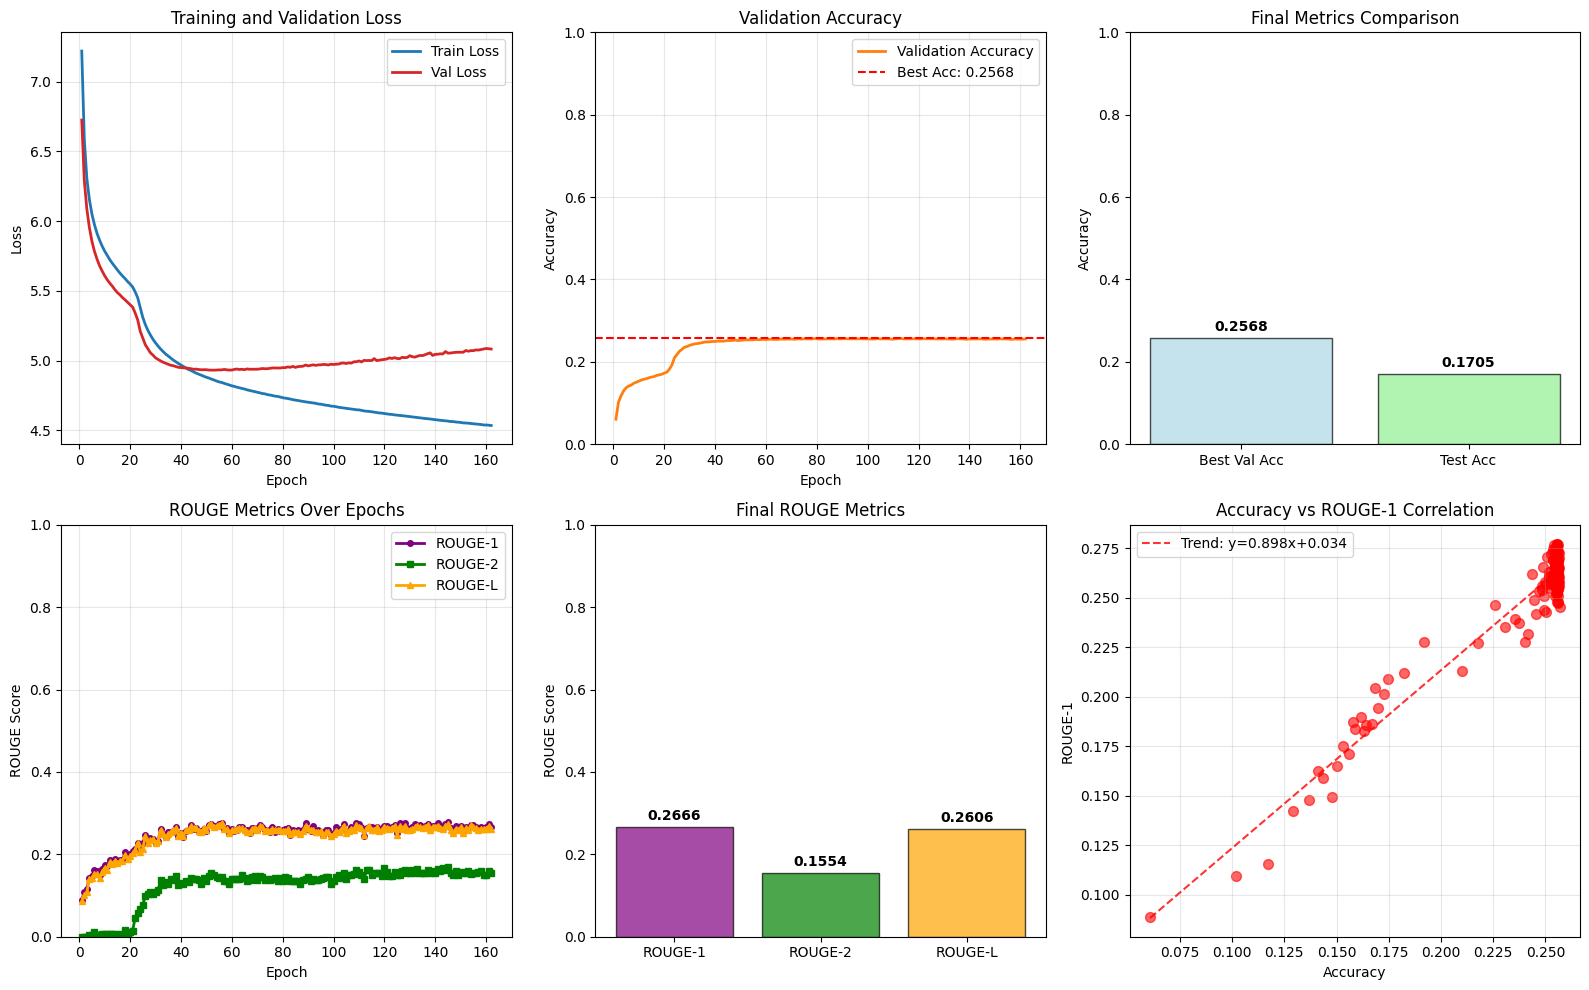

📊 Графики сохранены в: training_results.png


In [14]:
# Визуализация результатов

create_visualization(
    train_losses=train_losses,
    val_losses=val_losses,
    val_accuracies=val_accuracies,
    best_val_acc=best_val_acc,
    test_accuracy=test_accuracy,
    val_rouge_metrics=val_rouge_metrics,
    #test_rouge_metrics=test_rouge,  # если есть тестовые ROUGE метрики
    config=config
)


print(f"📊 Графики сохранены в: training_results.png")


In [15]:
# сравнение RNN LSTM vs transformer (distilGPT2)
# Конфигурация
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Используется устройство: {device}")

# Пути к данным и модели
# data_path = config['data_dir'] / '1_raw_dataset_tweets.txt'
model_path = Path(current_dir) / 'models' / 'best_model.pth'
# model_path = config['model_dir'] / 'lstm_50K_best_model.pth' #модель обученная на 50тыс. сообщений
# print(data_path,model_path)

#формируем/загружаем данные
# if v_from_file: 
test=load_samples(v_file_path / 'test_dataset.csv')        
# else:

#     _, _,test = samples_preparation(
#         v_file_path,
#         config['source_file'],
#         100)
# train_ds, val_ds, test_ds, train_loader, val_loader, test_loader

# test_ds,  test_loader = dataset_preparation(test, tokenizer, MAX_LEN=20, batch_size=128)
print("Создание тестового датасета.")
test_ds,  test_loader = dataset_preparation(
    test, 
    tokenizer, 
    MAX_LEN=config['MAX_LEN'], 
    batch_size=config['batch_size'],
    shuffle=False)

🖥️ Используется устройство: cuda
Таблица загружена: c:\Users\OMEN\Documents\LLM_Test\YaPracticum\project1_text-autocomplete_v3\data\test_dataset.csv
Создание тестового датасета.
Preparing X, Y pairs...


100%|██████████| 50000/50000 [00:05<00:00, 9393.13it/s] 

PAIRS ARE READY!
✅ Датасет создан: Size=40843


In [17]:
# 2) Тестируем LSTM модель
results_lstm = None
lstm_tokenizer=tokenizer
if model_path.exists():
    try:
        results_lstm = test_lstm_model(model_path, test_loader, lstm_tokenizer, device)
    except Exception as e:
        print(f"❌ Ошибка при тестировании LSTM модели: {e}")
else:
    print(f"❌ Файл модели LSTM не найден: {model_path}")


🧠 ТЕСТИРОВАНИЕ LSTM МОДЕЛИ
❌ Ошибка при тестировании LSTM модели: Error(s) in loading state_dict for NextPhrasePredictionRNN:
	Unexpected key(s) in state_dict: "rnn.weight_ih_l1", "rnn.weight_hh_l1", "rnn.bias_ih_l1", "rnn.bias_hh_l1". 


In [ ]:
#сравниваем генерацию фразы равной по количеству токенов урезанной части
# 3 модели: LSTM , GRU, distilGPT2
results, stats, best_model = compare_models_lstm_vs_gpt2()